# Our Approach to Solve for the Eigenvalues of a Hubbard Model Using Trotterization

## The Hamiltonian for a Hubbard Model is defined as:

$$ H = -t \sum_{i,\sigma} (c^†_{i,\sigma} c_{i+1,\sigma} + c^†_{i+1,\sigma} c_{i,\sigma}) + U \sum_i n_{i,\uparrow} n_{i,\downarrow} $$

where:
- \( t \) : tunneling amplitude (kinetic energy term)
- \( U \) : interaction strength (potential energy term)
- \( i \) : site number
- \( \sigma \) : Spin value, \( \uparrow \) or \( \downarrow \)
- \( c^†, c \) : creation and annihilation operators
- \( n_{i,\sigma} \) : number operator

## For a simple 2-site Hubbard Model, the Hamiltonian can be written as:

$$ H = H_t + H_U $$
$$ H_t = -t (c^†_{1,\sigma} c_{2,\sigma} + c^†_{2,\sigma} c_{1,\sigma}) $$
$$ H_U = U n_{1,\uparrow} n_{1,\downarrow} + U n_{2,\uparrow} n_{2,\downarrow} $$

Since \( H_t \) and \( H_U \) are non-commuting, Trotterization can be used to approximate the time evolution operator:

$$ e^{-iHt} \approx (e^{-iH_t \Delta t} e^{-iH_U \Delta t})^N $$

Here, we choose \( N = 100 \).

## To simulate the effect of the kinetic term, we use:
1. controlled-X gate (CX)
2. rotational-Z gate (RZ)
3. controlled-X gate (CX)
   - to implement a conditional phase shift which "hops" the particles between the two sites

## For the on-site interactions (U term), we apply:
1. rotational-Z gate (RZ)
   - to implement a phase shift which corresponds to the energy cost of having particles occupy the same state.

## Using Qiskit to create the Quantum circuit:


In [ ]:
 pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.7 MB/s eta 0:00:00


In [ ]:
pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.0 MB/s eta 0:00:00


In [ ]:
pip install qiskit_nature

In [245]:
from scipy.optimize._lsq.common import print_header_nonlinear
from qiskit_nature.second_q.hamiltonians import *
from qiskit_nature.second_q.hamiltonians.lattices import *
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit import Aer, transpile
from qiskit_nature import settings
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import Statevector
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, TrotterQRTE
from qiskit.synthesis import SuzukiTrotter
from qiskit_nature.second_q.operators import FermionicOp
import numpy as np
from qiskit.quantum_info import *
import matplotlib.pyplot as plt


### MAIN HUBBARD MODEL SIMULATON FUNCTION CALL ###
# @param: num_sites (int) number of sites on lattice
# @param: t (int)
# @param: u (int)
# @param: v (int)
# @param: steps (int) number of Trotterization steps
# @param: initial_conditions (statevector)
# @param: perturbation (FermionicOp) optional
def HubbardModel(num_sites, t, u, v, time, steps, initial_conditions, perturbation = None):
  # Create a Line Lattice with n sites
  line_lattice = LineLattice(num_nodes=num_sites, boundary_condition=BoundaryCondition.OPEN)

  # Create the Fermi-Hubbard model based on this line lattice
  fermi_hubbard_model = FermiHubbardModel(
      line_lattice.uniform_parameters(
          uniform_interaction= t,
          uniform_onsite_potential=v,
      ),
      onsite_interaction= u,
  )

  # Transform Hamiltonian of the Fermi-Hubbard model to FermionicOp
  second_q_op = fermi_hubbard_model.second_q_op()

  hamiltonian = second_q_op
  if perturbation is not None:
    hamiltonian = second_q_op + perturbation

  # Use the Jordan-Wigner transformation to map to qubit operators
  mapper = JordanWignerMapper()
  qubit_hamiltonian = mapper.map(hamiltonian) # final sparse gate hamiltonian

  # Define Time Evolution Operator
  evolution_problem = TimeEvolutionProblem(hamiltonian = qubit_hamiltonian, initial_state = initial_condition, time = time, aux_operators=[qubit_hamiltonian])

  # Do trotterization
  suz = SuzukiTrotter(order=3)
  trotter = TrotterQRTE(num_timesteps = steps, product_formula=suz, estimator=Estimator())
  result = trotter.evolve(evolution_problem)

  return result


In [239]:

def print_results(result, description = "Energy vs. Time"):
  # PROCESS RESULTS
  circuit = result.evolved_state
  sv = Statevector(circuit)
  observables = result.observables

  # PROBABILITIES
  for key,val in sv.probabilities_dict().items():
    val = round(val, 1)
    print("state:", key, "=>", val)

  # ENERGY OF SYSTEM
  print(observables[0][0][0])

  energy = []
  for observable in observables:
    energy.append(observable[0][0])
    # print("Energy", observable[0][0])

  # PLOT THE ENERGIES
  time = np.linspace(0,steps,steps+1)

  plt.plot(time, energy)
  plt.ylim(0,50)
  plt.title(description)
  plt.ylabel('Energy')
  plt.xlabel('Time')

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.9
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.1
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.1
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.0
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
20.0


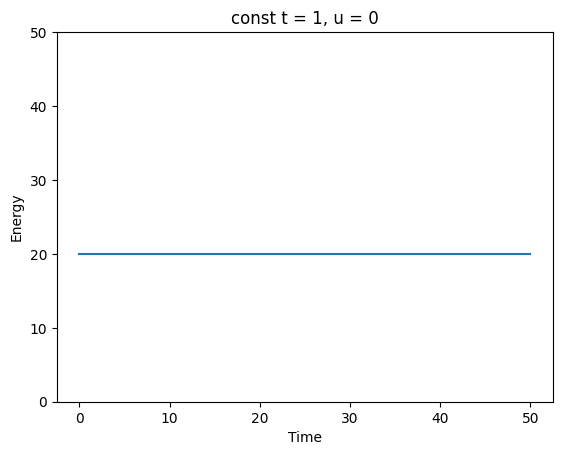

In [220]:
# DEFINE PARAMETERS
num_sites = 2
t = 1.0
u = 0
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const t = 1, u = 0")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 1.0
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.0
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.0
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.0
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
25.0


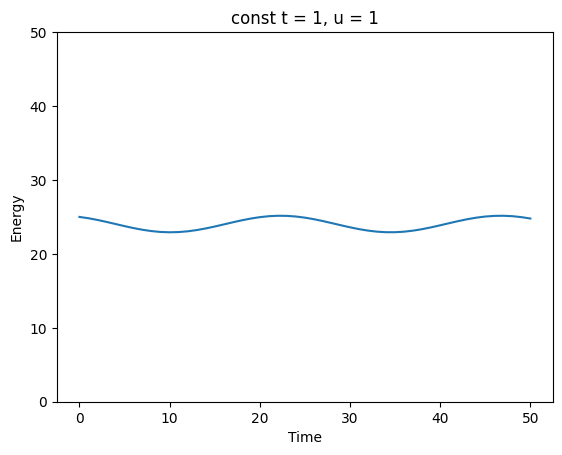

In [218]:
# DEFINE PARAMETERS
num_sites = 2
t = 1.0
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const t = 1, u = 1")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.2
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.2
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.2
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.4
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
30.0


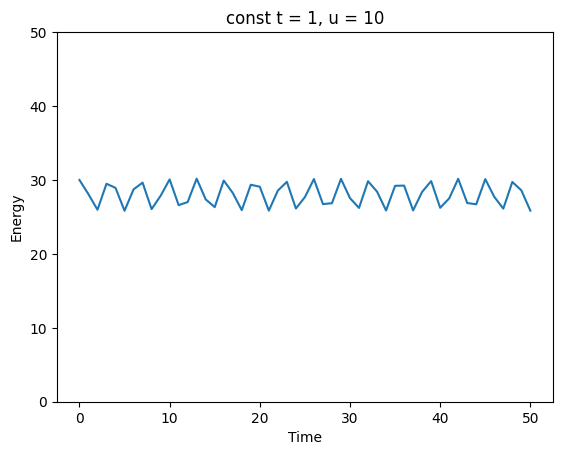

In [230]:
# DEFINE PARAMETERS
num_sites = 2
t = 1.0
u = 10
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const t = 1, u = 10")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0100 => 0.0
state: 1000 => 0.0
state: 1100 => 1.0
21.0


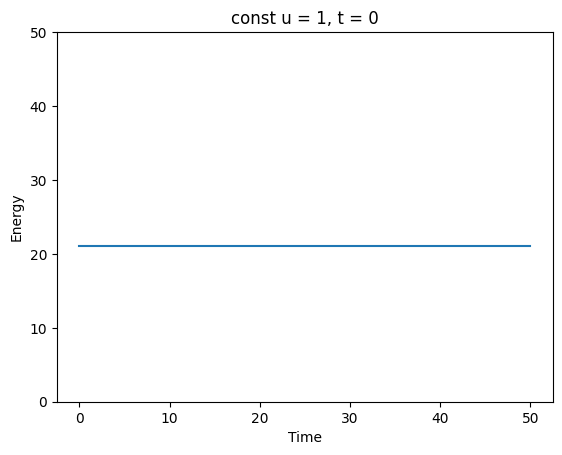

In [229]:
# DEFINE PARAMETERS
num_sites = 2
t = 0
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const u = 1, t = 0")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.6
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.1
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.1
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.1
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


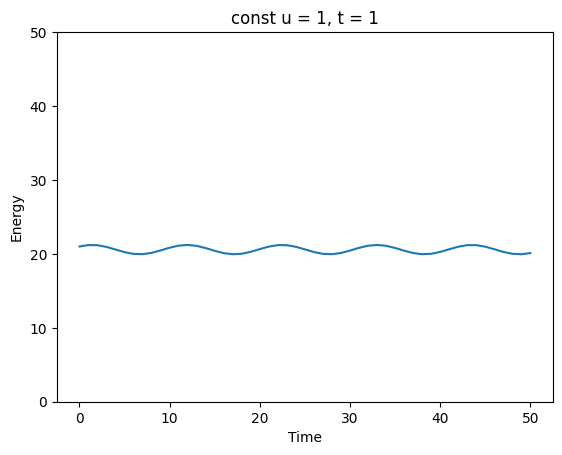

In [224]:
# DEFINE PARAMETERS
num_sites = 2
t = 1
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const u = 1, t = 1")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.8
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.0
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.0
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.2
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


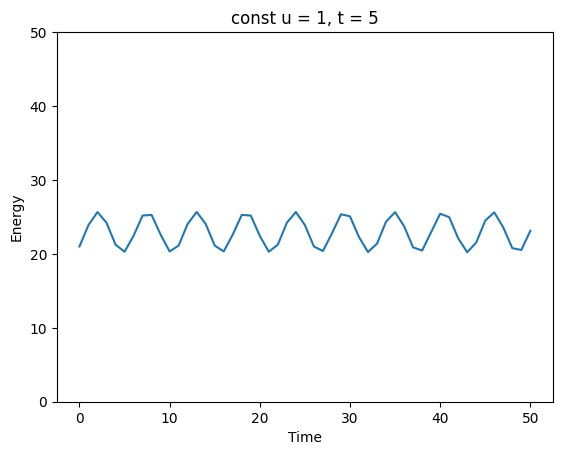

In [227]:
# DEFINE PARAMETERS
num_sites = 2
t = 5
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const u = 1, t = 5")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.1
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.0
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.0
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.8
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


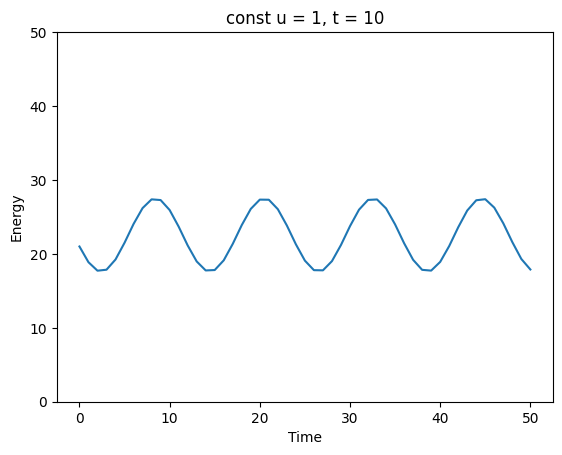

In [244]:
# DEFINE PARAMETERS
num_sites = 2
t = 10
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const u = 1, t = 10")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.1
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.0
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.0
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.8
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


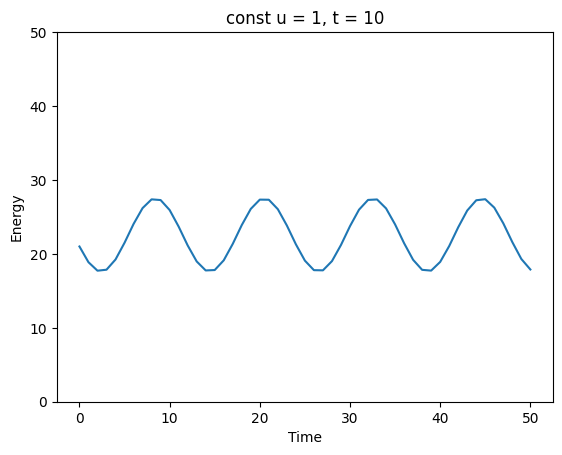

In [243]:
# DEFINE PARAMETERS
num_sites = 2
t = 10
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "const u = 1, t = 10")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.9
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.1
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.1
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.0
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


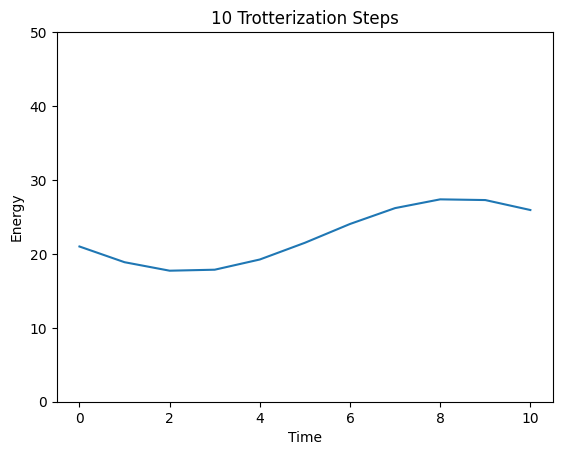

In [242]:
# DEFINE PARAMETERS
num_sites = 2
t = 10
u = 1
v = 10
time = 20
steps = 10
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "10 Trotterization Steps")

<ipython-input-189-00612115a3a9>:68: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  suz = SuzukiTrotter(order=3)


state: 0000 => 0.0
state: 0001 => 0.0
state: 0010 => 0.0
state: 0011 => 0.1
state: 0100 => 0.0
state: 0101 => 0.0
state: 0110 => 0.0
state: 0111 => 0.0
state: 1000 => 0.0
state: 1001 => 0.0
state: 1010 => 0.0
state: 1011 => 0.0
state: 1100 => 0.8
state: 1101 => 0.0
state: 1110 => 0.0
state: 1111 => 0.0
21.0


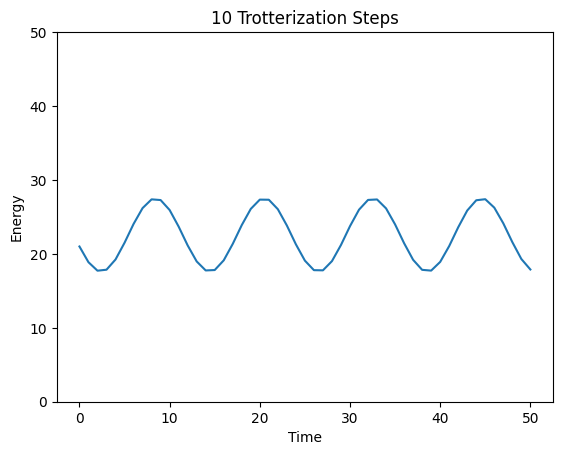

In [233]:
# DEFINE PARAMETERS
num_sites = 2
t = 10
u = 1
v = 10
time = 20
steps = 50
initial_condition = Statevector.from_label("1100")

# MAIN CALL
result2 = HubbardModel(2, t, u, v, time, steps, initial_condition)
print_results(result2, "50 Trotterization Steps")